In [1]:
import pandas as pd
import numpy as np
import pydicom
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from PIL import Image 
from os import listdir

elementdict = {'STUDYDATE' : 3, 
               'STUDYTIME' : 4, 
               'AGE' : 14, 
               'SEX' : 13, 
               'VIEWPOSITION' : 16}

# For 1st Checkpoint

In [2]:
folder = './data/'
trainfolder = folder + 'stage_2_train_images/'
testfolder = folder + 'stage_2_test_images/'
file1 = folder + 'stage_2_train_labels.csv'
file2 = folder + 'stage_2_detailed_class_info.csv'

In [3]:
dflabel = pd.read_csv(file1)
dflabel.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
dfinfo = pd.read_csv(file2)
dfinfo.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [5]:
dcmfiles = [f for f in listdir(testfolder)]
dftestdata = pd.DataFrame(dcmfiles, columns=['filename'])
dftestdata.filename = dftestdata.filename.apply(lambda x: x.replace('.dcm', ''))
dftestdata.head()

,filename
0,0000a175-0e68-4ca4-b1af-167204a7e0bc
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d
4,00100a24-854d-423d-a092-edcf6179e061


In [6]:
print(dfinfo['class'].unique())
print(len(dflabel), len(dfinfo), len(dflabel.patientId.unique()), len(dfinfo.patientId.unique()))

['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']
30227 30227 26684 26684


In [7]:
df = dflabel.merge(dfinfo, how='inner', on='patientId')
del(dfinfo)
del(dflabel)
df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [8]:
def ExtractInfo(dcmdata, identifiers):
    lstdata = list(dcmdata.elements())
    retval = []
    for idx in identifiers:
        try:
            tempval = lstdata[identifiers[idx]].value
            retval.append(tempval)
        except:
            print('Extraction failed', idx)

    return retval

def ReadInfo(path, lstpatients):
    lstvals = []
    lstpixels = []
    for item in range(len(lstpatients)):
        pid = lstpatients[item]

        if item % 5000 == 0: 
            print('Processings {0} - {1}'.format(item, pid))
    
        file = folder + path + pid + '.dcm'
        datadcm = pydicom.read_file(file)
        lstvals.append(ExtractInfo(datadcm, elementdict))
        lstpixels.append(datadcm.pixel_array.flatten())
    
    dfelements = pd.DataFrame(lstvals)
    dfelements['PIXELS'] = lstpixels
    dfelements.columns = ['STUDYDATE', 'STUDYTIME', 'AGE', 'SEX', 'VIEWPOSITION', 'PIXELS']
    return dfelements

dfelements = ReadInfo('stage_2_train_images/', list(df.patientId))

Processings patient 0 - 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Processings patient 5000 - 390eb7b5-2719-408a-b9ac-7ad6225c4889
Processings patient 10000 - 587b1026-7986-420e-aea4-ec1cef23af11
Processings patient 15000 - 7b8e6b7c-06c0-4006-8cbe-f1d92edeed07
Processings patient 20000 - 9c3edffc-7981-40c3-84b9-d719e49ce1db
Processings patient 25000 - b77ab795-de76-4715-b371-eb7be54b584c
Processings patient 30000 - d5d6f7e3-5143-4955-901e-cad92024fee0
Processings patient 35000 - f9c4f02b-52b5-4f36-96d7-b706d678d9b9


In [9]:
df[['studydate', 'studytime', 'age', 'sex', 'viewposition', 'pixels']] = dfelements.copy()
df['imagesize'] = df.pixels.apply(lambda x: x.shape)
df = df[['patientId', 'x', 'y', 'width', 'height', 
         'age', 'sex', 'viewposition', 'Target', 'class', 'pixels']]
df.age = df.age.apply(lambda x: np.int32(x))

del(dfelements)
df.head()

,patientId,x,y,width,height,age,sex,viewposition,Target,class,pixels
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,51,b'F ',b'PA',0,No Lung Opacity / Not Normal,"[144, 128, 114, 105, 94, 82, 72, 66, 59, 54, 4..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,48,b'F ',b'PA',0,No Lung Opacity / Not Normal,"[31, 24, 19, 14, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,19,b'M ',b'AP',0,No Lung Opacity / Not Normal,"[4, 12, 11, 10, 10, 8, 9, 7, 10, 10, 10, 9, 9,..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,28,b'M ',b'PA',0,Normal,"[209, 211, 212, 212, 210, 207, 205, 204, 204, ..."
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,32,b'F ',b'AP',1,Lung Opacity,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ..."


Age distribution by class


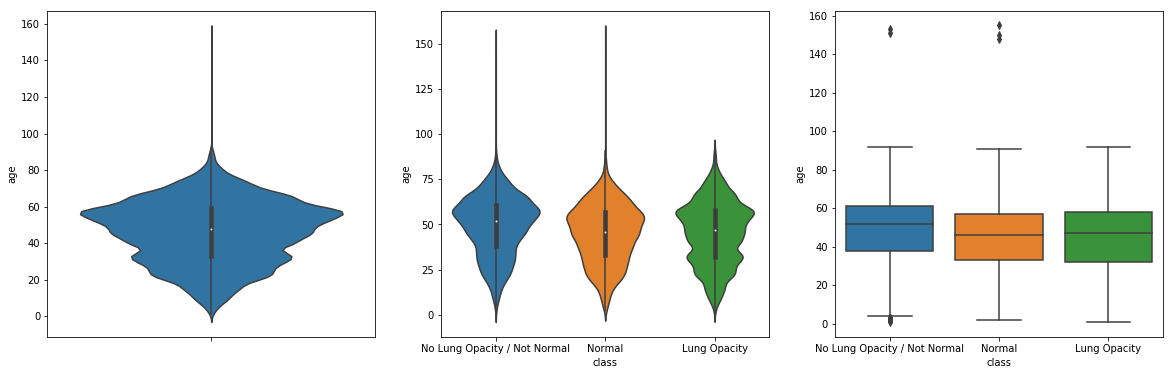

Age distribution by sex


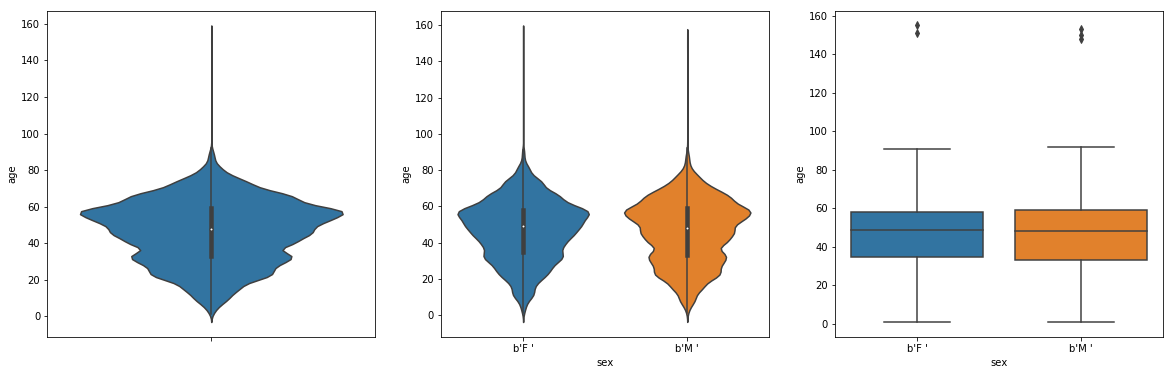

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))

print('Age distribution by class')
sb.violinplot(y ='age', data = df, ax=axes[0]) 
sb.violinplot(x ='class', y ='age', data = df, ax=axes[1]) 
sb.boxplot(x ='class', y ='age', data = df, ax=axes[2]) 
plt.show()

fig, axes = plt.subplots(1, 3, figsize = (20, 6))

print('Age distribution by sex')
sb.violinplot(y ='age', data = df, ax=axes[0]) 
sb.violinplot(x ='sex', y ='age', data = df, ax=axes[1]) 
sb.boxplot(x ='sex', y ='age', data = df, ax=axes[2]) 
plt.show()

Image view for class - No Lung Opacity / Not Normal


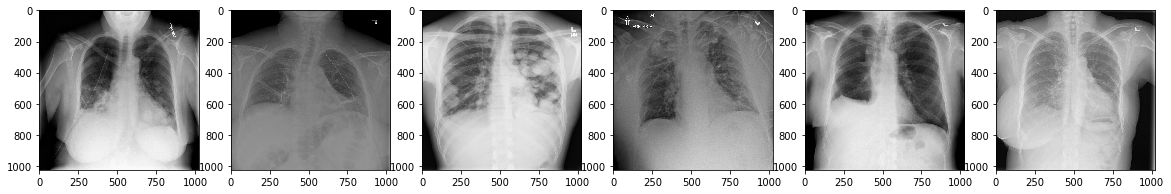

Image view for class - Normal


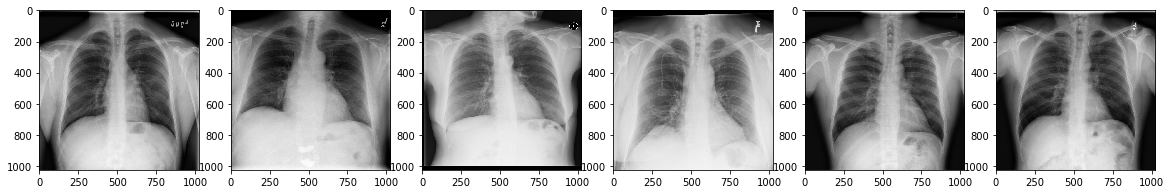

Image view for class - Lung Opacity


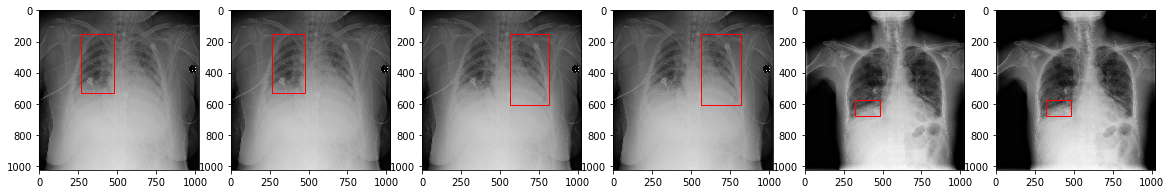

In [11]:
for cls in df['class'].unique():
    dftemp = df[df['class'] == cls].head(6)
    print('Image view for class - {0}'.format(cls))
    fig, axes = plt.subplots(1, len(dftemp), figsize = (20, 6))
    for i in range(len(dftemp)):
        pixels = dftemp.iloc[i].pixels.reshape((1024,1024))
        dimensions = dftemp.iloc[i][['x', 'y', 'width', 'height']]
        axes[i].imshow(pixels, cmap='gray')
        
        if not np.isnan(dimensions[0]):
            rect = patches.Rectangle((dimensions[0],dimensions[1]),
                                     dimensions[2],dimensions[3], 
                                     linewidth=1, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)
        
    plt.show()

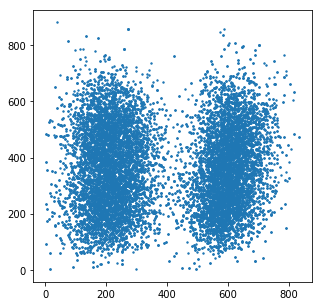

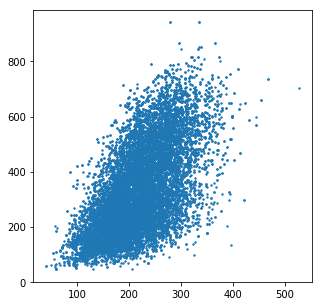

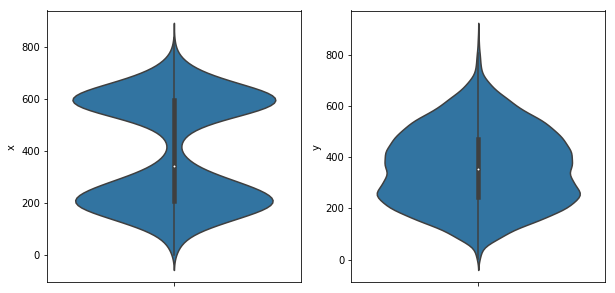

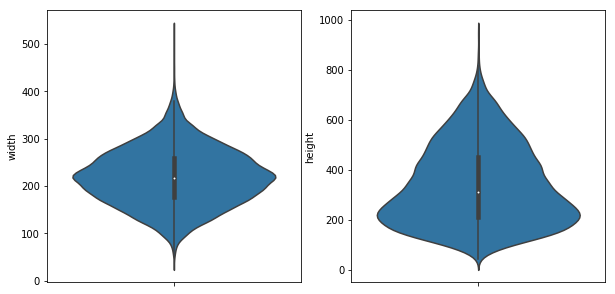

In [12]:
fig, axes = plt.subplots(1, 1, figsize = (5, 5))
plt.scatter(df.x, df.y, s=2)
plt.show()

fig, axes = plt.subplots(1, 1, figsize = (5, 5))
plt.scatter(df.width, df.height, s=2)
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sb.violinplot(data=df[df.Target == 1],  y='x', ax=axes[0])
sb.violinplot(data=df[df.Target == 1],  y='y', ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sb.violinplot(data=df[df.Target == 1],  y='width', ax=axes[0])
sb.violinplot(data=df[df.Target == 1],  y='height', ax=axes[1])
plt.show()

In [13]:
df.corr()

,x,y,width,height,age,Target
x,1.000000,0.021598,-0.069520,-0.007830,-0.010099,NaN
y,0.021598,1.000000,-0.296784,-0.641857,0.100815,NaN
width,-0.069520,-0.296784,1.000000,0.605735,0.026475,NaN
height,-0.007830,-0.641857,0.605735,1.000000,-0.007733,NaN
age,-0.010099,0.100815,0.026475,-0.007733,1.000000,-0.062877
Target,NaN,NaN,NaN,NaN,-0.062877,1.000000


# For 2nd Checkpoint

ML1 - identify if the dcm file provided is a good quality image (normal or opaque) or not (not normal). 
ML2 - The images that pass through ML1 (normal or opaque) will be fed to the second model.

#### Internals of Model 1
The imagesize in all cases are 1024 X 1024 and hence the trainable parameters are huge. The following steps are the outlined steps for this model. 

1. Mark all the 'Normal' and 'Lung Opacity' classes as 0 and 'No Lung Opacity / Not Normal' as 1. 
2. Resize all the pixel array from 1024 X 1024 images to 64 X 64 images. I am trying to reduce the number of trainable parameters by reducing the size of the image for training in this model. 
3. Scale the image gray scale pixels to a standard scaler. No meta data is considered for this as the meta data is not needed to classify the quality of image. 
4. Test train split is done with a randomized state (for reproduciability) with the split size of about 80% / 20%.
5. Train labels will be convered to one hot encoded array. There will be 2 columns one corresponding to 'Normal' and 'Lung Opacity' classes and another corresponding to 'No Lung Opacity / Not Normal' 
6. Build a keras dense neural network pipeline with variable hidden layers and neurons. The pipeline will have the final layers activate through sigmoid with 2 outputs. We can go for binary single output if needed... 
7. Train the model and evaulate the model performance at the end. 

In [14]:
# step 1 - define alternative target - No Lung Opacity / Not Normal
df['notnormaltarget'] = df['class'].apply(lambda x: 1 if x == 'No Lung Opacity / Not Normal' else 0)

In [15]:
# step 2 - resize images to 64 X 64
resizearr = (64,64)
df['resizedpixels'] = df.pixels.apply(lambda x: np.asarray(Image.fromarray(np.uint8(x.reshape((1024,1024)))).resize(resizearr)).flatten())

In [16]:
# Extract the data as x and y. x will have only patient id for traceablity, resized pixel array and y will be the 
# alternative target labels.
dfdata = df[['patientId', 'resizedpixels', 'notnormaltarget']]
x =  pd.DataFrame(list(dfdata.resizedpixels))
y = dfdata.notnormaltarget

In [18]:
# step 3 - scale the gray scale pixel values using standard scaler. We can use other scalers if needed. 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
xdata = sc.fit_transform(x)
ydata = list(y)

In [19]:
# step 4 - train test split with a random state of 10 and split size of 80% to 20%
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size = 0.2, random_state=10)
len(xtrain), len(ytrain), len(xtest), len(ytest)

(30103, 30103, 7526, 7526)

In [1]:
# step 5 - Convert the alternative target to one hot vectors. 
from sklearn.preprocessing import OneHotEncoder 
ytrain = np.asarray(ytrain).reshape(-1, 1)
ytest =  np.asarray(ytest).reshape(-1, 1)
encoder = OneHotEncoder()
ytrain = encoder.fit_transform(ytrain).toarray()
ytest = encoder.transform(ytest).toarray()

NameError: name 'np' is not defined

In [ ]:
# import keras and dependent packages. 
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# step 6 - Build ML1 pipeline with hidden layers. The choice of number of neurons are based on the gradual reduction 
# in the scale of 2 to maintain consistency of trainable parameters. The last output layer is softmax activate to predict 
# normal/opaque images or not nomal images. In this iteration, i have used SGD optimizer and categorical_crossentrophy loss
# functions. I will be evaulating the models using accuracy. 
model = Sequential()
model.add(Dense(1024, input_dim=4096, activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(256,  activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy']) # We can use adam optimizer

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total para

In [24]:
# Train the model for 20 epochs with the batch size of 1000. 
history = model.fit(xtrain, ytrain, epochs=20, batch_size=1000)

Epoch 1/20
30103/30103 [==============================] - 20s 659us/step - loss: 0.6409 - acc: 0.6602
Epoch 2/20
30103/30103 [==============================] - 18s 614us/step - loss: 0.6149 - acc: 0.6855
Epoch 3/20
30103/30103 [==============================] - 18s 607us/step - loss: 0.6047 - acc: 0.6874
Epoch 4/20
30103/30103 [==============================] - 18s 607us/step - loss: 0.5961 - acc: 0.6886
Epoch 5/20
30103/30103 [==============================] - 18s 596us/step - loss: 0.5890 - acc: 0.6922
Epoch 6/20
30103/30103 [==============================] - 18s 605us/step - loss: 0.5822 - acc: 0.6973
Epoch 7/20
30103/30103 [==============================] - 18s 601us/step - loss: 0.5758 - acc: 0.7012
Epoch 8/20
30103/30103 [==============================] - 18s 614us/step - loss: 0.5699 - acc: 0.7054
Epoch 9/20
30103/30103 [==============================] - 19s 625us/step - loss: 0.5646 - acc: 0.7093
Epoch 10/20
30103/30103 [==============================] - 19s 616us/step - loss: 

In [25]:
# Evaluation of training data. 
model.evaluate(xtrain, ytrain)

30103/30103 [==============================] - 18s 596us/step


[0.5005638088846716, 0.7491944324505732]

In [26]:
# Evaluation of test data. 
model.evaluate(xtest, ytest)

7526/7526 [==============================] - 5s 612us/step


[0.5607718550284556, 0.7095402604305076]

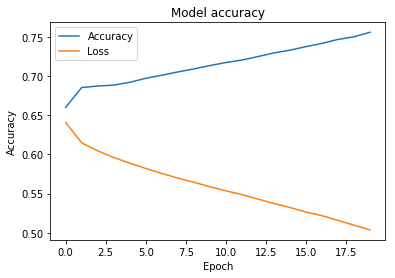

In [27]:
# Visualization corresponding to the training process between accuracy and loss. As you can see, the accuracy or 
# loss parameters are not stablizing. It means that, there is more scope to train this model for more epochs.  
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [28]:
# with 50% confidence applied on the notnormaltarget, the model predicts about 75% for correct labels. 
ypred = list(map(lambda x: 1 if x > 0.5 else 0, model.predict(xdata)[:, 1]))

In [29]:
print(model.evaluate(xdata, encoder.transform(np.asarray(ydata).reshape(-1, 1))))
print('Confusion matrix \n' , pd.crosstab(np.array(ydata), np.array(ypred), rownames=['Actual'], colnames=['Predicted']))

37629/37629 [==============================] - 26s 678us/step
[0.5126057377594397, 0.7412633872668303]
Confusion matrix 
 Predicted      0     1
Actual                
0          24621  1187
1           8549  3272


In [2]:
# Visualize the predicted images
dfdata['prediction'] = pd.Series(ypred)
sample = 10

print('===> Not normal')
dftemp = dfdata[dfdata.prediction == 1].sample(sample)
fig, axes = plt.subplots(1, len(dftemp), figsize = (20, 6))
for i in range(len(dftemp)):
    pixels = dftemp.iloc[i].resizedpixels.reshape((64,64))
    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title('Act - ' + str(dftemp.iloc[i].notnormaltarget) + '; Pred - ' +  str(dftemp.iloc[i].prediction) )
plt.show()

print('===> Normal and Opaque')
dftemp = dfdata[dfdata.prediction == 0].sample(sample)
fig, axes = plt.subplots(1, len(dftemp), figsize = (20, 6))
for i in range(len(dftemp)):
    pixels = dftemp.iloc[i].resizedpixels.reshape((64,64))
    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title('Act - ' + str(dftemp.iloc[i].notnormaltarget) + '; Pred - ' +  str(dftemp.iloc[i].prediction) )
plt.show()

NameError: name 'pd' is not defined

#### Internals of Model 2

Model 2 will be classifying the images with opacity 

In [31]:
# The helper function will split the 2d image to specified amount of images equally in equal direction. Each squred portion 
# will be evaluated if it has any opacity. 
def split_array(data, splitby=2):

    stepi = data.shape[0] / splitby
    stepj = data.shape[1] / splitby

    data_array = []
    for i in range(splitby):
        for j in range(splitby):
            data_array.append(data[np.int(i*stepi):np.int((i+1)*stepi), np.int(j*stepj):np.int((j+1)*stepj)])
            
    return data_array

# Test the above function to split an image of (1024, 1024) size to multiple (32, 32) equal images. 
data = df.pixels.iloc[0].reshape((1024,1024))
data = split_array(data, splitby=32)
print(len(data), data[0].shape)

1024 (32, 32)


In [3]:
# preprocess data... delete few columns from the dataframe and age will be binarized to differnent column. 
del(df['notnormaltarget'])
del(df['resizedpixels'])

try:
    df.sex = df.sex.apply(lambda x: x.strip().decode('utf-8'))
except:
    print('Already adjusted age')
    
try:
    df.viewposition = df.viewposition.apply(lambda x: x.strip().decode('utf-8'))
except:
    print('Already adjusted view position')

df [['sexF', 'sexM']] = pd.get_dummies(df.sex)
df [['vpAP', 'vpPA']] = pd.get_dummies(df.viewposition)

# max value is 100
def agebinarize(x):
    
    retval = list(str(bin(x)).replace('0b',''))
    while len(retval) < 7:
        retval = ['0'] + retval
        
    return retval

df.adjustedage = df.age.apply(lambda x: x if x <= 100 else 100)
df[['age7', 'age6', 'age5', 'age4', 'age3', 'age2', 'age1']] = pd.DataFrame(list(df.adjustedage.apply(agebinarize)), 
                                                                            columns = ['age7', 'age6', 'age5', 'age4', 'age3', 'age2', 'age1'])

df.head()

NameError: name 'df' is not defined

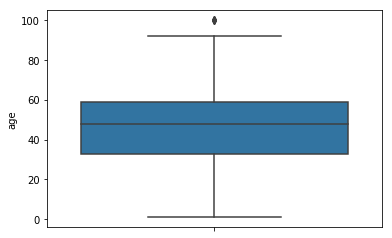

In [38]:
sb.boxplot(y =df.adjustedage) 
plt.show()

In [39]:
# View clean data after features are categorized. 
dfdatafull = df[df['class'].apply(lambda x: False if x == 'No Lung Opacity / Not Normal' else True)][['patientId', 'x', 'y', 
                                                                                                      'width', 'height', 'Target', 
                                                                                                      'pixels', 'age7', 'age6', 
                                                                                                      'age5', 'age4', 'age3', 
                                                                                                      'age2', 'age1', 'sexF', 
                                                                                                      'sexM', 'vpAP', 'vpPA']]
dfdatafull = dfdatafull.reset_index(drop=True)
dfdatafull.head()

,patientId,x,y,width,height,Target,pixels,age7,age6,age5,age4,age3,age2,age1,sexF,sexM,vpAP,vpPA
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,"[209, 211, 212, 212, 210, 207, 205, 204, 204, ...",0,0,1,1,1,0,0,0,1,0,1
1,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0
2,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0
3,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0
4,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0


In [40]:
# Helper function to generate x and y coordinates for bounding boxes. 
def GetMaxValue(x):
    mn = x[0]
    mx = x[1]
    
    retval = np.nan
    
    if (not np.isnan(mn)) and (not np.isnan(mx)):
        retval = mn + mx
        
    return retval

dfdatafull['xmin'] = dfdatafull.x
dfdatafull['ymin'] = dfdatafull.y
dfdatafull['xmax'] = pd.Series(zip(dfdatafull.x, dfdatafull.width)).apply(GetMaxValue)
dfdatafull['ymax'] = pd.Series(zip(dfdatafull.y, dfdatafull.height)).apply(GetMaxValue)
del(dfdatafull['x'])
del(dfdatafull['y'])
del(dfdatafull['width'])
del(dfdatafull['height'])
dfdatafull.head()

,patientId,Target,pixels,age7,age6,age5,age4,age3,age2,age1,sexF,sexM,vpAP,vpPA,xmin,ymin,xmax,ymax
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,"[209, 211, 212, 212, 210, 207, 205, 204, 204, ...",0,0,1,1,1,0,0,0,1,0,1,NaN,NaN,NaN,NaN
1,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,264.0,152.0,477.0,531.0
2,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,264.0,152.0,477.0,531.0
3,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,562.0,152.0,818.0,605.0
4,00436515-870c-4b36-a041-de91049b9ab4,1,"[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...",0,1,0,0,0,0,0,1,0,1,0,562.0,152.0,818.0,605.0


In [41]:
# Helper function to generated masked datalabels. 
def MakeMasks(x):
    pix = x[0]
    xmin, xmax, ymin, ymax = pix = x[1], x[2], x[3], x[4]
    zeros = np.zeros((1024,1024))
    
    if (not np.isnan(xmin)):
        zeros[np.int(xmin):np.int(xmax), np.int(ymin):np.int(ymax)] = 1
    
    return zeros

In [42]:
# Generate masked data labels. 
masks = pd.Series(zip(dfdatafull.pixels, dfdatafull.xmin, dfdatafull.xmax, dfdatafull.ymin, dfdatafull.ymax)).apply(MakeMasks)

MemoryError: 